In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

def parse_coords(coords):
    return [float(x) for x in coords.split('-')]

def get_x(filename):
    x_pd = pd.read_csv(filename, header=None)
    x_pd_parsed = x_pd.applymap(parse_coords)
    x_np = x_pd_parsed.to_numpy()
    return np.array([[x for x in y] for y in x_np[:]])

def get_y(filename):
    x_pd = pd.read_csv(filename, header=None)
    return x_pd.to_numpy()

In [3]:
X = get_x('data/train_x.csv')
y = get_y('data/train_y.csv').reshape((-1))

X_test = get_x('data/test_x.csv')
y_test = get_y('data/test_y.csv').reshape((-1))

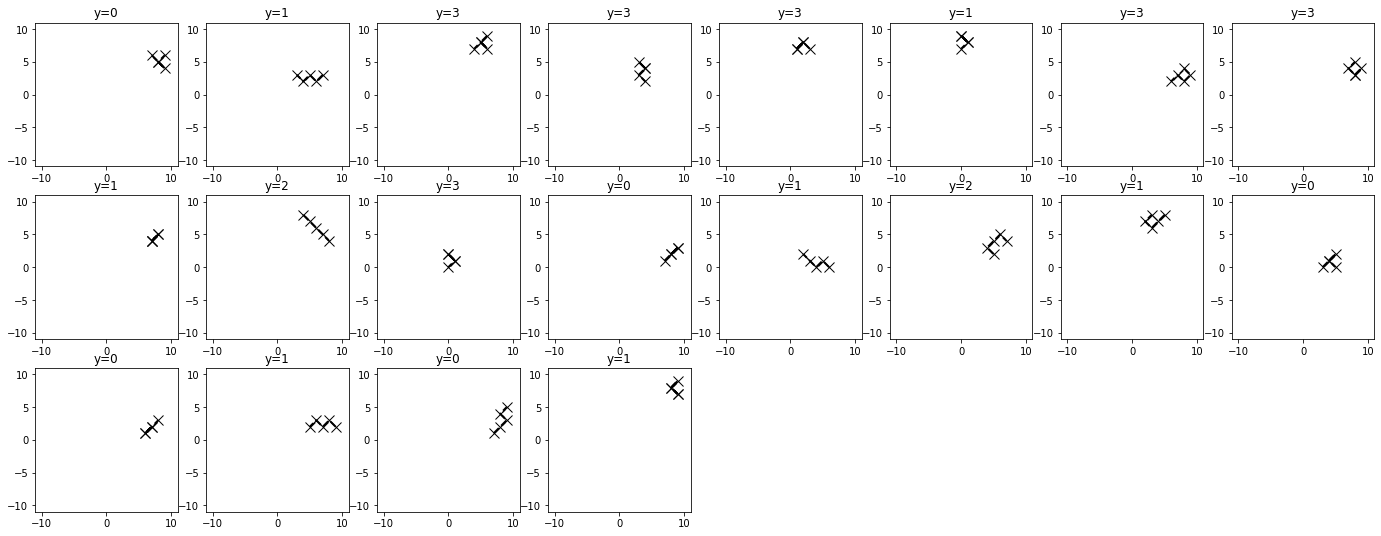

In [4]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches




def plot_path(verts, ax):
#     ax.axis('off')
    
    xs, ys = zip(*verts)
    ax.plot(xs, ys, 'x--', lw=2, color='black', ms=10)

    i=0
    for x,y in verts:
        rand_x,rand_y = np.random.rand(2)-0.5
#         ax.text(x+rand_x, y+rand_y, 'P'+str(i))
        i += 1

    min_x,max_x = -10,10  #np.min(verts[:,0]),np.max(verts[:,0])
    min_y,max_y = -10,10  #np.min(verts[:,1]),np.max(verts[:,1])


    ax.set_xlim(min_x - 1, max_x + 1)
    ax.set_ylim(min_y - 1, max_y + 1)
    
def plot_many(samples, labels=None):
    n = (samples.shape[0])
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 8
        rows = int((n+cols-1)/cols)
        fig = plt.figure(figsize=(cols * 3, rows * 3))
    
    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        if labels is not None :
            sub.title.set_text('y={0}'.format(labels[i]))
        else :
            sub.title.set_text('nolabel')
        plot_path(samples[i], sub)

n = 20
plot_many(X[:n], y[:n])

### See if you can create a hypotesis about what is the difference between classes.
I have absolutely no clue about what is the connection between classes. 

In [5]:
import torch.nn as nn
import torch
import torch.nn.functional as F

torch.manual_seed(1)

class Net(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, embedding_dim,drop_prob):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        
#         self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        self.embedding = nn.Embedding(100, embedding_dim)
        
        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, sentence):
        hidden = (torch.randn(1,sentence.shape[0],  self.hidden_dim), torch.randn(1,sentence.shape[0], self.hidden_dim))
#         print(sentence.shape)
        embeds = self.embedding(sentence)
#         print(embeds.shape)
        lstm_out, _ = self.lstm(embeds, hidden)
#         print(lstm_out.shape)
        lstm_out = lstm_out[:,-1,:]
    
        out = self.dropout(lstm_out)
#         print(lstm_out.shape)
        tag_space = self.hidden2tag(out)
#         print(tag_space.shape)
        tag_scores = F.log_softmax(tag_space, dim=1)
#         print(tag_scores.shape)
        return tag_scores

n_hidden = 124
n_letters = 2
n_categories = 4
embedding_dim = 2
drop_prob = 0.1

model = Net(n_letters, n_hidden, n_categories, embedding_dim, drop_prob)

In [6]:
from torchvision.transforms.functional import to_tensor


arr = torch.randperm(100).long()

Xt = to_tensor(X).float().permute(1,2,0)
print(Xt.shape)
Xe = Xt.clone()
Xe[:,:,0] *= 10
Xe = arr[Xe.sum(dim=2).long()]
print(Xe.shape)
# print(Xt[:2])
# print(Xe[:2])
inp = Xe[0:2]
print(inp.shape[1])
# print(inp.shape)
output = model(inp)
print(output)

torch.Size([9000, 5, 2])
torch.Size([9000, 5])
5
tensor([[-1.3749, -1.4230, -1.3789, -1.3692],
        [-1.3423, -1.4405, -1.3698, -1.3951]], grad_fn=<LogSoftmaxBackward>)


In [7]:
import torch.optim as optim

loss_function = nn.NLLLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.004)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    row = Xe[0:1]
    sentence_in = row
    tag_scores = model(sentence_in)
    print(tag_scores)
    targets = torch.tensor(y[0:1], dtype=torch.long)
    print(targets)
    los = loss_function(tag_scores, targets)
    print(los)

loss_log = []
acc_log = []
test_acc_log = []

X_test_tens = to_tensor(X_test).float().permute(1,2,0)

    

tensor([[-1.3610, -1.3992, -1.3864, -1.3991]])
tensor([0])
tensor(1.3610)


epoch 0 loss 10936.929033994675
epoch 10 loss 6988.253400921822


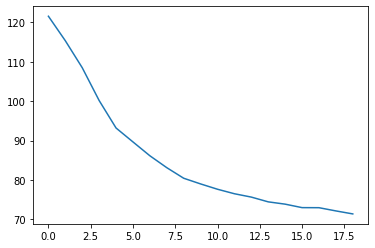

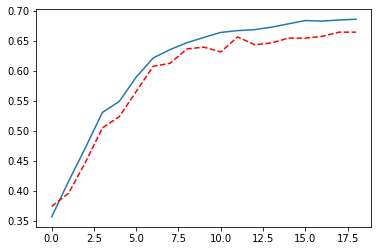

In [8]:

optimizer = optim.Adam(model.parameters(), lr=0.005)
batch_size = 100
batches = int(len(Xt)/batch_size)

def accuracy(testX, testY):
# Go through a bunch of examples and record which are correctly guessed
    testXe = testX.clone()
    testXe[:,:,0] *= 10
    testXe = arr[testXe.sum(dim=2).long()]

    with torch.no_grad():
        tag_scores = model(testXe)
#         print(tag_scores.shape)
        targets = torch.tensor(testY, dtype=torch.long)
#         print(targets.shape)
            
    acc = ((tag_scores.argmax(dim=1) == targets).sum().float()/float(testY.shape[0])).item()
#     print('acc:', acc)
    return acc

embedding_log = []


for epoch in range(19):  # again, normally you would NOT do 300 epochs, it is toy data
    acc_loss = 0
    
    for i in range(batches) :
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        n = i * batch_size
        sentence_in = Xe[n:n+batch_size]
        targets = torch.tensor(y[n:n+batch_size], dtype=torch.long)
        
        with torch.no_grad():
            if i == 0 :
                embedding_log.append(model.embedding(sentence_in))
        
        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        acc_loss += loss.item()
        loss.backward()
        optimizer.step()
    loss_log.append(acc_loss)
    
    acc = accuracy(Xt, y)
    acc_test = accuracy(X_test_tens, y_test)
    acc_log.append(acc)
    test_acc_log.append(acc_test)
    if epoch % 10 == 0 :
        print("epoch", epoch, "loss", acc_loss*batches)


plt.figure()
plt.plot(loss_log, label='truncated')
plt.figure()
plt.plot(acc_log)
plt.plot(test_acc_log, 'r--')


In [9]:
accuracy(Xt, y)

0.6941111087799072

In [10]:
X_test_tens = to_tensor(X_test).float().permute(1,2,0)
accuracy(X_test_tens, y_test)

0.656000018119812

(9000, 5, 2)
-4.547019
3.4361544


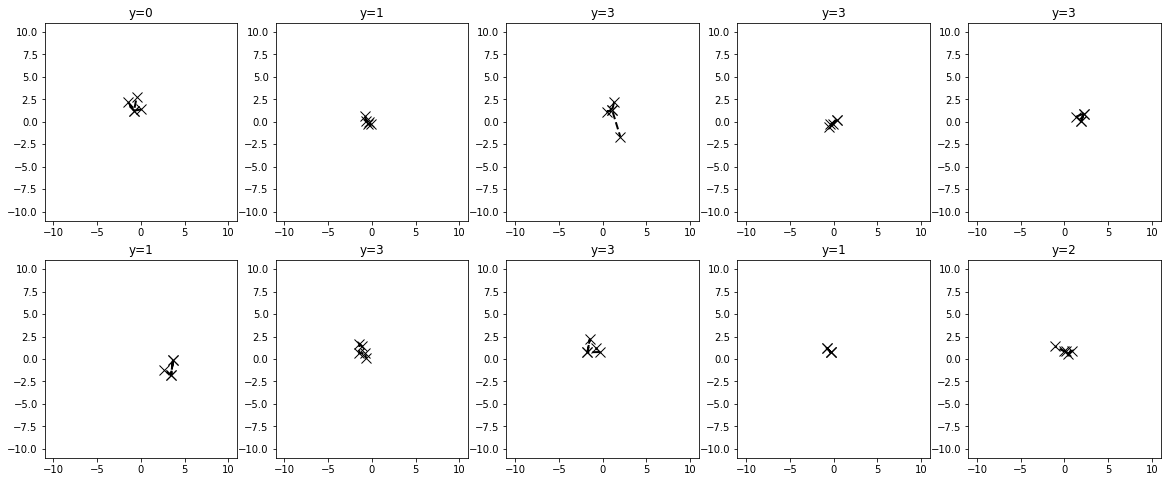

In [11]:
n = 10
embedded = model.embedding(Xe).detach().numpy()
print(embedded.shape)
print(embedded[:,:,1].min())
print(embedded[:,:,1].max())

plot_many(embedded[:n], y[:n])

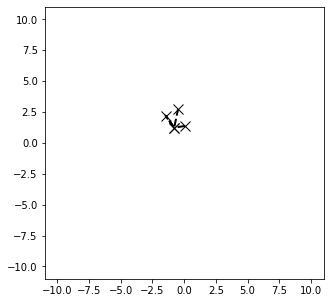

In [12]:

def plot_path2(verts, ax):
#     ax.axis('off')
    
    xs, ys = zip(*verts)
    ax.plot(xs, ys, 'x--', lw=2, color='black', ms=10)

    i=0
    for x,y in verts:
        rand_x,rand_y = np.random.rand(2)-0.5
#         ax.text(x+rand_x, y+rand_y, 'P'+str(i))
        i += 1

    min_x,max_x = -10,10  #np.min(verts[:,0]),np.max(verts[:,0])
    min_y,max_y = -10,10 #np.min(verts[:,1]),np.max(verts[:,1])


    ax.set_xlim(min_x - 1, max_x + 1)
    ax.set_ylim(min_y - 1, max_y + 1)
    
def plot_many2(samples, labels=None):
    n = (samples.shape[0])
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 8
        rows = int((n+cols-1)/cols)
        fig = plt.figure(figsize=(cols * 3, rows * 3))
    
    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        if labels is not None :
            sub.title.set_text('y={0}'.format(labels[i]))
        else :
            sub.title.set_text('nolabel')
        plot_path2(samples[i], sub)

fig = plt.figure(figsize=(5, 5))
sub = fig.add_subplot(1, 1, 1)
plot_path2(embedded[0], sub)

In [13]:
emb1 = ([x[0] for x in embedding_log])
emb1[0].shape

torch.Size([5, 2])

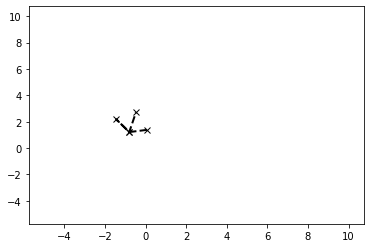

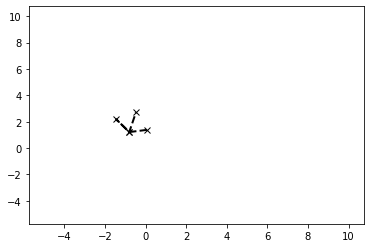

In [14]:
from IPython.display import display, clear_output
import time



def plot_animated(emb1, ax):
    l, = ax.plot([-5,10],[-5,10],'x--',lw=2, color='black')

    get_data = lambda i: zip(*emb1[i])

    animate = lambda i: l.set_data(*get_data(i))
    
    return animate

fig, ax = plt.subplots()
anim = plot_animated(emb1, ax)
for i in range(len(emb1)):
    anim(i)
    clear_output(wait=True)
    display(fig)
    time.sleep(0.05)

plt.show()

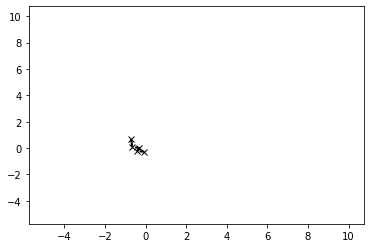

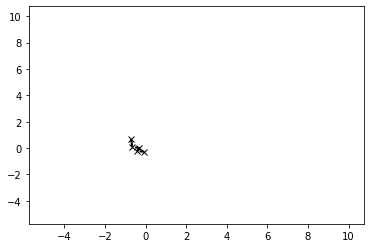

In [15]:
emb2 = ([x[1] for x in embedding_log])

fig, ax = plt.subplots()
anim = plot_animated(emb2, ax)
for i in range(len(emb2)):
    anim(i)
    clear_output(wait=True)
    display(fig)
    time.sleep(0.05)

plt.show()

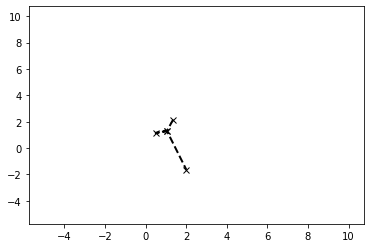

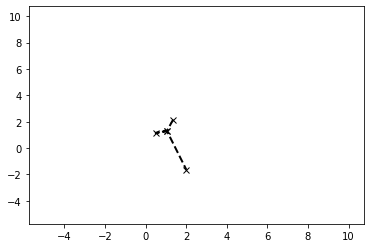

In [16]:
emb3 = ([x[2] for x in embedding_log])

fig, ax = plt.subplots()
anim = plot_animated(emb3, ax)
for i in range(len(emb3)):
    anim(i)
    clear_output(wait=True)
    display(fig)
    time.sleep(0.05)

plt.show()

### Find out and visualise similarities and differences between this two structures.
The shape is always percieved, what changes is the distances between some of the points.

In [21]:
maps = model.embedding(arr).detach().numpy()
idxs = np.array([[x//10, x%10] for x in range(100)])

In [57]:
# rand_idxs = np.unique((np.random.rand((40))*100).astype(np.int))
rand_idxs = np.arange(10).astype(np.int)*10

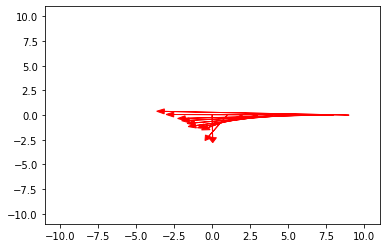

In [59]:
def plot_arrow(point_from, point_to, ax):
    x,y = point_from
    dx, dy = point_to - point_from
    ax.arrow(x,y,dx,dy, head_width=0.5, head_length=0.5, color='r')

ax = plt.axes()

min_x,max_x = -10,10  #np.min(verts[:,0]),np.max(verts[:,0])
min_y,max_y = -10,10 #np.min(verts[:,1]),np.max(verts[:,1])


ax.set_xlim(min_x - 1, max_x + 1)
ax.set_ylim(min_y - 1, max_y + 1)

for idx in rand_idxs:
    plot_arrow(idxs[idx], maps[idx], ax)



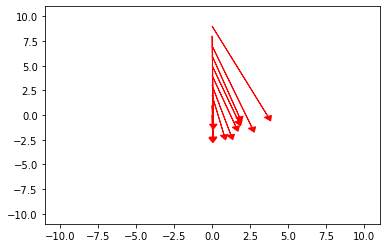

In [61]:
rand_idxs = np.arange(10).astype(np.int)

def plot_arrow(point_from, point_to, ax):
    x,y = point_from
    dx, dy = point_to - point_from
    ax.arrow(x,y,dx,dy, head_width=0.5, head_length=0.5, color='r')

ax = plt.axes()

min_x,max_x = -10,10  #np.min(verts[:,0]),np.max(verts[:,0])
min_y,max_y = -10,10 #np.min(verts[:,1]),np.max(verts[:,1])


ax.set_xlim(min_x - 1, max_x + 1)
ax.set_ylim(min_y - 1, max_y + 1)

for idx in rand_idxs:
    plot_arrow(idxs[idx], maps[idx], ax)



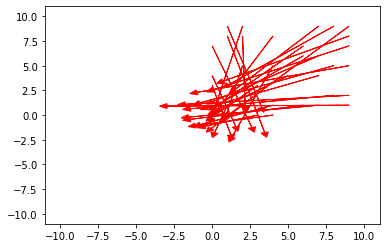

In [62]:
rand_idxs = np.unique((np.random.rand((40))*100).astype(np.int))

def plot_arrow(point_from, point_to, ax):
    x,y = point_from
    dx, dy = point_to - point_from
    ax.arrow(x,y,dx,dy, head_width=0.5, head_length=0.5, color='r')

ax = plt.axes()

min_x,max_x = -10,10  #np.min(verts[:,0]),np.max(verts[:,0])
min_y,max_y = -10,10 #np.min(verts[:,1]),np.max(verts[:,1])


ax.set_xlim(min_x - 1, max_x + 1)
ax.set_ylim(min_y - 1, max_y + 1)

for idx in rand_idxs:
    plot_arrow(idxs[idx], maps[idx], ax)



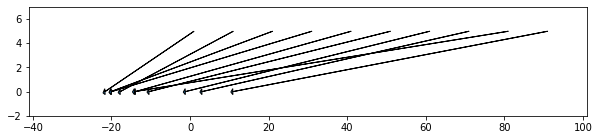

In [65]:
rand_idxs = np.arange(10).astype(np.int)+10

def plot_arrow2(point_from, point_to, ax):
    x1,y1 = point_from
    x1 = x1 + y1*10
    y1 = 5
    x2,y2 = point_to
    x2 = x2 + y2*10
    y2=0
    ax.arrow(x1,y1,x2-x1,y2-y1, head_width=0.5, head_length=0.5)

plt.figure(figsize=(10,2))
ax = plt.axes()

min_x,max_x = -40,100  #np.min(verts[:,0]),np.max(verts[:,0])
min_y,max_y = -1,6 #np.min(verts[:,1]),np.max(verts[:,1])


ax.set_xlim(min_x - 1, max_x + 1)
ax.set_ylim(min_y - 1, max_y + 1)

for idx in rand_idxs:
    plot_arrow2(idxs[idx], maps[idx], ax)